# Simulated aneling for iterate design optimizing $\kappa$ for better efficiency

✔ Material DB loaded: c:\Users\Administrator\Desktop\users\Daniel\Waveguide_1550F_775SHG\xcut_zcut_linbo3.mdf
⚠ No checkpoint found, starting fresh.
thickness LN 6e-07

=== λ = 1030.0 nm ===
✔ Strongest Ey mode index: 10
✔ Max |Ey| at center: 0.8967346303436643
✔ n_eff: [[1.70616436+0.j]]

=== λ = 515.0 nm ===
✔ Strongest Ey mode index: 2
✔ Max |Ey| at center: 0.9242630304070233
✔ n_eff: [[2.09534481+0.j]]
thickness LN 6e-07

=== λ = 1030.0 nm ===
✔ Strongest Ey mode index: 10
✔ Max |Ey| at center: 0.9203024827700335
✔ n_eff: [[1.71766402+0.j]]

=== λ = 515.0 nm ===
✔ Strongest Ey mode index: 0
✔ Max |Ey| at center: 0.8397943947040893
✔ n_eff: [[2.18611364+0.j]]
step 0, T=2.850, best |kappa|=1.689e+05
💾 Saved checkpoint at step 0 -> best_mode_solution_1030.0nm.npz
thickness LN 6e-07

=== λ = 1030.0 nm ===
✔ Strongest Ey mode index: 10
✔ Max |Ey| at center: 0.9090743170678488
✔ n_eff: [[1.7139706+0.j]]

=== λ = 515.0 nm ===
✔ Strongest Ey mode index: 2
✔ Max |Ey| at center: 0.9314757285

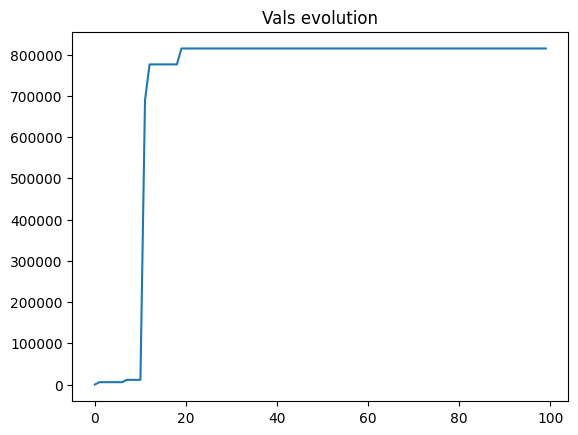

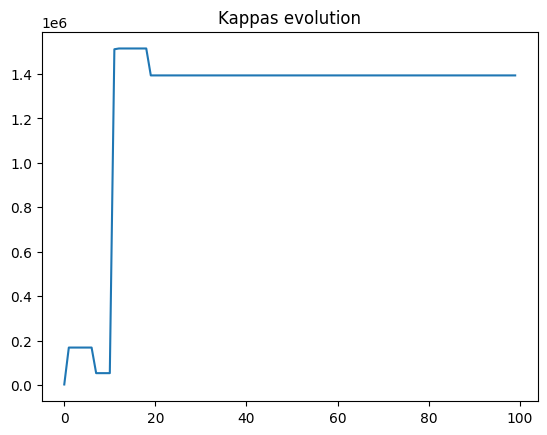

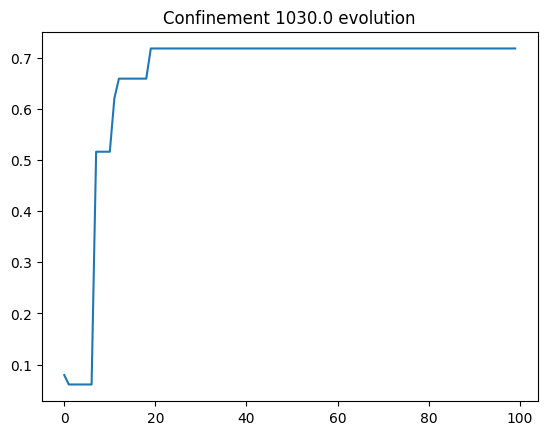

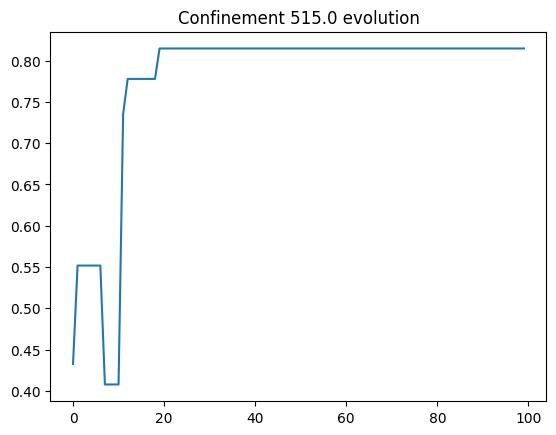

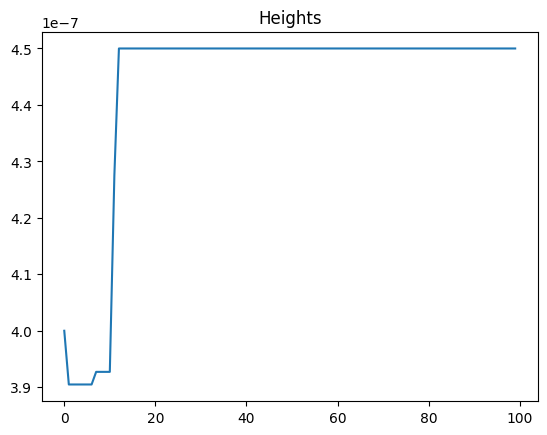

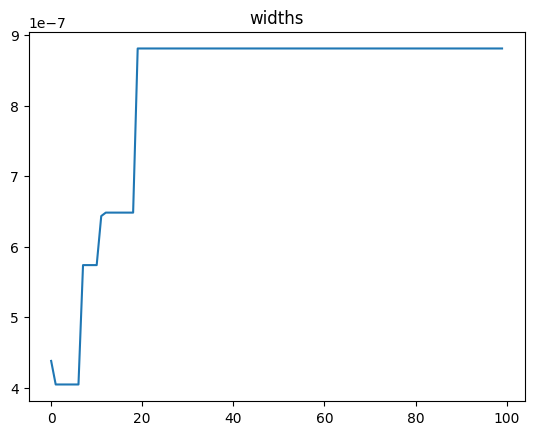

In [ ]:
from automation_lumerical import *
from optimization_lumerical import *
import numpy as np
import matplotlib.pyplot as plt

L_core=50e-6
y_span=8e-6
n_trial_modes=25
angle = 60

lambda0=1.310e-6
lambda1=lambda0/2
wavelengths = [lambda0, lambda1] 

mode = initialize_lumerical_MODE()
T= 3
n_steps=100
best_h, best_w, best_val, best_kappa, best_confinement, hs, ws, vals, kappas, confinements = anneal(
    mode,
    h0=0.40e-6,
    w0=0.9e-6,
    h_bounds=(0.2e-6, 0.45e-6),
    w_bounds=(0.8e-6, 2e-6),
    L_core=L_core,
    y_span=y_span,
    n_trial_modes=n_trial_modes,
    angle=angle,
    wavelengths=wavelengths,
    n_steps=n_steps,
    checkpoint_file=f"./{lambda0*1e9}nm files/best_mode_solution_{wavelengths[0]*1e9}nm.npz",
    T0=T,

    resume=True
)

print("SA best h, w =", best_h, best_w, " |kappa|=", best_kappa)

plt.figure(1)
plt.plot(vals)
plt.title("Vals evolution")

plt.figure(2)
plt.plot(kappas)
plt.title("Kappas evolution")

plt.figure(3)
plt.plot(confinements[:,0])
plt.title(f"Confinement {lambda0*1e9} evolution")

plt.figure(4)
plt.plot(confinements[:,1])
plt.title(f"Confinement {lambda1*1e9} evolution")

plt.figure(5)
plt.plot(hs)
plt.title("Heights")

plt.figure(6)
plt.plot(np.array(ws)-2*hs/np.tan(np.deg2rad(angle)))
plt.title("widths")


mode, cfg = build(mode, best_h, best_w, L_core, y_span, n_trial_modes, angle)
Electric_fields, n_effs, indices = solve_wavelengths(mode, cfg, wavelengths)

np.savez(f"best_mode_solution_{lambda0*1e9}nm.npz", Electric_fields=Electric_fields, n_effs=n_effs, indices=indices, best_h=best_h, best_w=best_w-2*best_h/np.tan(np.deg2rad(angle)),
        best_val=best_val, best_kappa=best_kappa, best_confinement = confinements,hs=hs,ws=ws,kappas=kappas,T=T,n_steps=n_steps)



# Iterations around optimal parameters

In [ ]:
from automation_lumerical import *
from optimization_lumerical import *
import gdsfactory as gf
from waveguide_tools import *

#lambda0=1.030e-6

def poling_period_shg(n, lam, c=2.99792458e17):
    """
    Compute the periodic poling period for SHG.

    Parameters
    ----------
    n : list or array
        [n_SH, n_FF] refractive indices.
    lam : list or array
        [lambda_SH, lambda_FF] wavelengths in nm.
    c : float
        Speed of light in nm/s. Default = 2.99792458e17 nm/s.

    Returns
    -------
    P : float
        Poling period in nm.

    Formulas
    --------
    k = (2*pi*n) / lambda
    Δk = k_SH - 2*k_FF
    P = 2*pi / Δk
    """

    n_FF, n_SH = n
    lam_FF, lam_SH= lam

    # Wavevectors
    k_SH = 2 * np.pi * n_SH / lam_SH
    k_FF = 2 * np.pi * n_FF / lam_FF

    # Phase mismatch
    Delta_k = k_SH - 2 * k_FF

    # Poling period
    P = 2 * np.pi / Delta_k
    print(f"pooling {np.abs(P[0][0])*1e6}")
    print(f"lam_SH {lam_SH}  lam_FF {lam_FF}")

    return np.abs(P[0][0])*1e6

data = np.load(f"./{lambda0*1e9}nm files/best_mode_solution_{lambda0*1e9}nm.npz", allow_pickle=True)

Electric_fields = data["Electric_fields"].tolist()   # list of dicts
n_effs = data["n_effs"]
indices = data["indices"]
h_best = data["best_h"]
w_best = data["best_w"]

n_waveguides = 10

#lambda0=1.555e-6
lambda1=lambda0/2
wavelengths = [lambda0, lambda1] 

pooling_period_optimum = poling_period_shg(n=n_effs, lam=wavelengths)
w_step = 0.005e-6

L_core=50e-6
y_span=8e-6
n_trial_modes=25
angle = 60
w_s = w_best+2*h_best/np.tan(np.deg2rad(angle)) + np.arange(-n_waveguides//2, n_waveguides//2+1) * w_step
pp_s_for_varying_width = []

mode = initialize_lumerical_MODE()
for w in w_s:
    mode, cfg = build(mode, h_best.tolist(), w, L_core, y_span, n_trial_modes, angle)
    Electric_, n_, idx = solve_wavelengths(mode, cfg, wavelengths)
    pp_s_for_varying_width.append(poling_period_shg(n=n_, lam=wavelengths))

pp_step = 0.001
pp_s_for_fixed_width = pooling_period_optimum + np.arange(-n_waveguides//2, n_waveguides//2+1) * pp_step
pp_s_for_varying_width = np.array(pp_s_for_varying_width)


pooling 2.928986891208801
lam_SH 5.15e-07  lam_FF 1.03e-06
✔ Material DB loaded: c:\Users\Administrator\Desktop\users\Daniel\Waveguide_1550F_775SHG\xcut_zcut_linbo3.mdf
thickness LN 6e-07

=== λ = 1030.0 nm ===
✔ Strongest Ey mode index: 0
✔ Max |Ey| at center: 0.9434105317762922
✔ n_eff: [[2.02422793+0.j]]

=== λ = 515.0 nm ===
✔ Strongest Ey mode index: 0
✔ Max |Ey| at center: 0.9243103974541808
✔ n_eff: [[2.20108848+0.j]]
pooling 2.9118987553165527
lam_SH 5.15e-07  lam_FF 1.03e-06
thickness LN 6e-07

=== λ = 1030.0 nm ===
✔ Strongest Ey mode index: 0
✔ Max |Ey| at center: 0.9435282824856999
✔ n_eff: [[2.02452259+0.j]]

=== λ = 515.0 nm ===
✔ Strongest Ey mode index: 0
✔ Max |Ey| at center: 0.9243844884395768
✔ n_eff: [[2.20117095+0.j]]
pooling 2.915396334991955
lam_SH 5.15e-07  lam_FF 1.03e-06
thickness LN 6e-07

=== λ = 1030.0 nm ===
✔ Strongest Ey mode index: 0
✔ Max |Ey| at center: 0.9436409471138585
✔ n_eff: [[2.02481217+0.j]]

=== λ = 515.0 nm ===
✔ Strongest Ey mode index: 0
✔

# GDS dessign

686
686
685
684
683
682
682
681
680
679
679
683
683
683
683
683
682
682
682
681
681
The height is 0.44999999999999996 the top width is 0.8812561567673644, [1.3758714 1.3808714 1.3858714 1.3908714 1.3958714 1.4008714 1.4058714
 1.4108714 1.4158714 1.4208714 1.4258714]


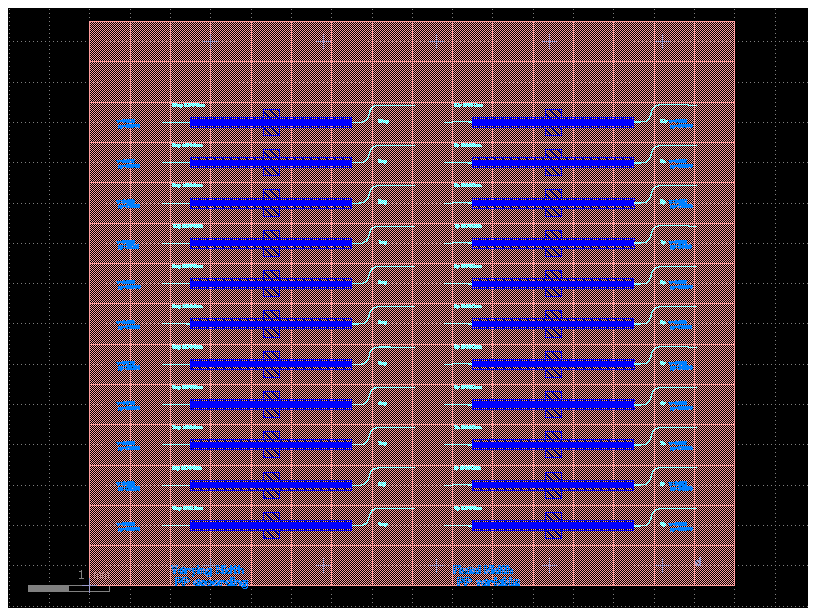

In [55]:
import gdsfactory as gf
from waveguide_tools import *

def poling_period_shg(n, lam, c=2.99792458e17):
    """
    Compute the periodic poling period for SHG.

    Parameters
    ----------
    n : list or array
        [n_SH, n_FF] refractive indices.
    lam : list or array
        [lambda_SH, lambda_FF] wavelengths in nm.
    c : float
        Speed of light in nm/s. Default = 2.99792458e17 nm/s.

    Returns
    -------
    P : float
        Poling period in nm.

    Formulas
    --------
    k = (2*pi*n) / lambda
    Δk = k_SH - 2*k_FF
    P = 2*pi / Δk
    """

    n_FF, n_SH = n
    lam_FF, lam_SH= lam

    # Wavevectors
    k_SH = 2 * np.pi * n_SH / lam_SH
    k_FF = 2 * np.pi * n_FF / lam_FF

    # Phase mismatch
    Delta_k = k_SH - 2 * k_FF

    # Poling period
    P = 2 * np.pi / Delta_k
    print(f"pooling {np.abs(P[0][0])*1e6}")
    print(f"lam_SH {lam_SH}  lam_FF {lam_FF}")

    return np.abs(P[0][0])*1e6



gf.clear_cache()
DBU = 0.001      # µm
GRID = 2 * DBU   # 0.002 µm

layers = {
    "field":   (1, 0),
    "ppln":    (2, 0),
    "metal":   (10, 0),
    "comment": (11, 0),
    "marker":  (4, 0),
}

@gf.cell
def structure(length=2000, width=0.5, pooling_period = 1)-> gf.Component: 

    width_in_out = 1.25
    component = gf.Component()

    taper_in_in = component << gf.components.taper(
        length=100,
        width1=width_in_out,       # input width fixed
        width2=width_in_out,     # waveguide width
        layer=layers["ppln"],
    )
    taper_in = component << gf.components.taper(
        length=200,
        width1=width_in_out,       # input width fixed
        width2=width,     # waveguide width
        layer=layers["ppln"],
    )
    waveguide = component << waveguide_bend(length=length, width=width, radius1=100, radius2=100, layer=layers["ppln"])
    taper_out = component << gf.components.taper(
        length=200,
        width1=width,       # input width fixed
        width2=width_in_out,     # waveguide width
        layer=layers["ppln"],
    )
    taper_out_out = component << gf.components.taper(
        length=100,
        width1=width_in_out,       # input width fixed
        width2=width_in_out,     # waveguide width
        layer=layers["ppln"],
    )
    taper_in_in.connect("o2",taper_in.ports["o1"])
    waveguide.connect("o1", taper_in.ports["o2"])
    taper_out.connect("o1",waveguide.ports["o2"])
    taper_out_out.connect("o1",taper_out.ports["o2"])

    
    electrodes = component << electrodes_x_cut(lenght=length, duty=0.3, period=pooling_period, prominence=30, metal_layer=layers["metal"], 
                     width_wg = width, gap = 1.75, alpha = 0.27,
                     pad_top_width = 30, pad_buttom_width = 30,
                     pad_top_touch_width=100, pad_buttom_touch_width=100)
    electrodes.movex(length/8)
    component.add_ports(waveguide.ports, prefix="WG_")

    return component

c = gf.Component("Waveguide_SHG")

n = 16
m = 14
field_reference = c << gf.components.pixel_array(pixels=('X'*n+'\n')*m+'\n', pixel_size=500, layer=layers["field"]).copy()
field_reference.movey(-750)
field_reference.movex(-1000)


length = 2000
vertical_separation = 500
second_column_distance = 3500

for i in range(n_waveguides+1):
    waveguide = c << structure(length=length, width=np.round((w_s[i]-2*h_best/np.tan(np.deg2rad(angle))).tolist()*1e6/ GRID) * GRID, pooling_period =pp_s_for_varying_width[i])
    waveguide.movey(i*vertical_separation)
    numl = c << gf.components.text(text=f"{i}wp {lambda0*1e9}nm", size=40, justify="left", layer=layers["ppln"])
    numl.movey(i*vertical_separation+200)
    numl.movex(20)
    numr = c << gf.components.text(text=f"{i}wp", size=40, justify="left", layer=layers["ppln"])
    numr.movey(i*vertical_separation)
    numr.movex(length+575)

    width_r = c << gf.components.text(text=f"w={np.round((w_s[i]-2*h_best/np.tan(np.deg2rad(angle))).tolist()*1e6/ GRID) * GRID} \n pp={pp_s_for_fixed_width[i]:.4f}", size=40, justify="left", layer=layers["comment"])
    width_r.movey(i*vertical_separation)
    width_r.movex(-675)


for i in range(n_waveguides+1):
    waveguide = c << structure(length=length, width=np.round(w_best.tolist()*1e6/ GRID) * GRID, pooling_period =pp_s_for_fixed_width[i])
    waveguide.movey(i*vertical_separation)
    waveguide.movex(second_column_distance)
    numl = c << gf.components.text(text=f"{i}p {lambda0*1e9}nm", size=40, justify="left", layer=layers["ppln"])
    numl.movey(i*vertical_separation+200)
    numl.movex(second_column_distance+20)
    numr = c << gf.components.text(text=f"{i}p", size=40, justify="left", layer=layers["ppln"])
    numr.movey(i*vertical_separation)
    numr.movex(second_column_distance+length+575)

    width_r = c << gf.components.text(text=f"w={np.round(w_best.tolist()*1e6/ GRID) * GRID} \n pp={pp_s_for_fixed_width[i]:.4f}", size=40, justify="left", layer=layers["comment"])
    width_r.movey(i*vertical_separation)
    width_r.movex(second_column_distance+length+675)

num_of_up_markers = 5
for i in range(num_of_up_markers):
    marker_1u = c << marker(layer=layers["marker"])
    marker_1u.movey(-vertical_separation)
    marker_1u.movex(i*2*second_column_distance/num_of_up_markers+500)

num_of_down_markers = 5
for i in range(num_of_down_markers):
    marker_1d = c << marker(layer=layers["marker"])
    marker_1d.movey((n_waveguides+2)*vertical_separation)
    marker_1d.movex(i*2*second_column_distance/num_of_up_markers+500)

marker_corner = c << marker(layer=layers["marker"])
marker_corner.movey(-750)
marker_corner.movex(-1000)

orientation = c << gf.components.text(text="d", size=100, justify="left", layer=layers["marker"])
orientation.movey(-vertical_separation) 
orientation.movex(2*second_column_distance-500)



coment1 = c << gf.components.text(text="Varying Width\n PP according", size=100, justify="left", layer=layers["comment"])
coment1.movey(-600) 
coment1.movex(0)

coment2 = c << gf.components.text(text="Fixed Width \n PP variable", size=100, justify="left", layer=layers["comment"])
coment2.movey(-600) 
coment2.movex(second_column_distance)



#array_of_trench_structures.show()
#array_of_trench_structures.draw_ports()
c
c.plot()
c.write_gds(f"./{lambda0*1e9}nm files/waveguide_shg_{lambda0*1e9}nm.gds")

print(f"The height is {h_best*1e6} the top width is {w_best*1e6}, {w_s*1e6}")


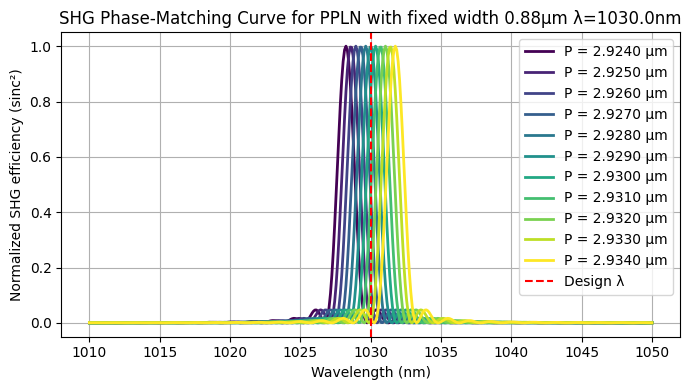

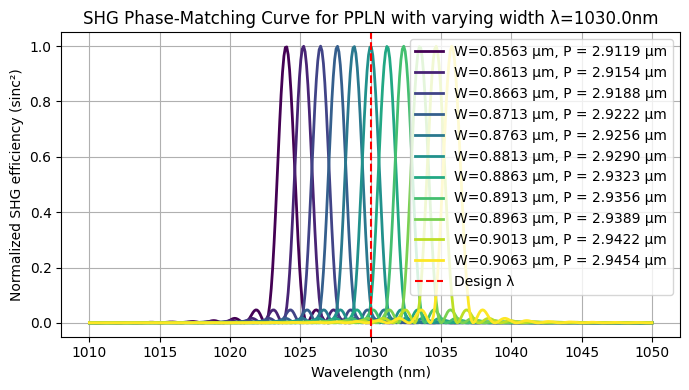

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1) Compute Δk(λ) for a range of wavelengths
# ---------------------------------------------------------

def k_vector(n, lam):
    """Wavevector 2πn/λ; lam in meters."""
    return 2*np.pi*n/lam

def delta_k(n_eff, lam_array, P):
    """
    n_model: function that returns refractive index n(λ)
    lam_array: array of FF wavelengths (m)
    P: poling period (m)
    """
    lam_SH = lam_array/2
    n_FF = n_eff[0]
    n_SH = n_eff[1]

    k_FF = k_vector(n_FF, lam_array)
    k_SH = k_vector(n_SH, lam_SH)

    delta_k = k_SH - 2*k_FF - 2*np.pi/P
    return delta_k


# ---------------------------------------------------------
# 2) Sinc efficiency curve
# ---------------------------------------------------------

def sinc_eff(delta_k, L):
    """Return normalized SHG efficiency sinc^2(ΔkL/2)."""
    return np.sinc(delta_k * L / (2*np.pi))**2


# ---------------------------------------------------------
# 3) Example refractive-index model
# (use Sellmeier, or your Lumerical neff if preferred)
# ---------------------------------------------------------

def n_model(λ):
    """Example: constant index (replace with Sellmeier)."""
    return 2.2 + 0*λ


# ---------------------------------------------------------
# 4) Parameters
# ---------------------------------------------------------

#lambda0 = 1.555e-6
lambda_range = np.linspace(lambda0-20e-9, lambda0+20e-9, 400)   # FF wavelengths
L = 2e-3                     # 30 mm PPLN
pp_step = 0.001

# ---------------------------------------------------------
# 5) Compute Δk(λ) and sinc^2 curve
# ---------------------------------------------------------
plt.figure(figsize=(7,4))

cmap = plt.cm.viridis   # choose your colormap
colors = cmap(np.linspace(0, 1, len(pp_s_for_fixed_width)))  # one unique color per curve

for i, p in enumerate(pp_s_for_fixed_width*1e-6): 
    Δk = delta_k(n_effs, lambda_range, p)
    eta = sinc_eff(Δk, L)
    plt.plot(lambda_range*1e9, eta[0], lw=2, color=colors[i], label=f"P = {p*1e6:.4f} µm")

plt.axvline(lambda0*1e9, color='r', ls='--', label='Design λ')

plt.xlabel("Wavelength (nm)")
plt.ylabel("Normalized SHG efficiency (sinc²)")
plt.title(f"SHG Phase-Matching Curve for PPLN with fixed width {w_best*1e6:.2f}µm λ={lambda0*1e9}nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f"./{lambda0*1e9}nm files/phase_matching_fixed_width_varying_pp_{lambda0*1e9}nm.png")
plt.show()

plt.figure(figsize=(7,4))
for i, (p, w) in enumerate(zip(pp_s_for_varying_width*1e-6, w_s-2*h_best/np.tan(np.deg2rad(angle)))): 
    Δk = delta_k(n_effs, lambda_range, p)
    eta = sinc_eff(Δk, L)
    plt.plot(lambda_range*1e9, eta[0], lw=2, color=colors[i], label=f"W={w*1e6:.4f} µm, P = {p*1e6:.4f} µm")

plt.axvline(lambda0*1e9, color='r', ls='--', label='Design λ')

plt.xlabel("Wavelength (nm)")
plt.ylabel("Normalized SHG efficiency (sinc²)")
plt.title(f"SHG Phase-Matching Curve for PPLN with varying width λ={lambda0*1e9}nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f"./{lambda0*1e9}nm files/phase_matching_varying_width_according_pp_{lambda0*1e9}nm.png")
plt.show()


# Auxiliary code non-essential

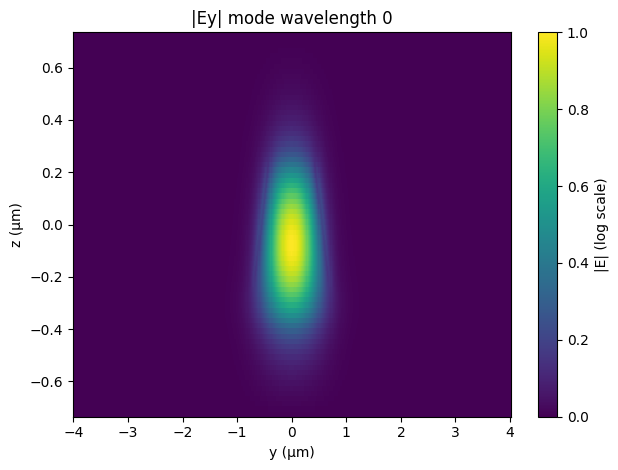

Integral Ey dA 0 = (5.047086338064765e-13+0j)


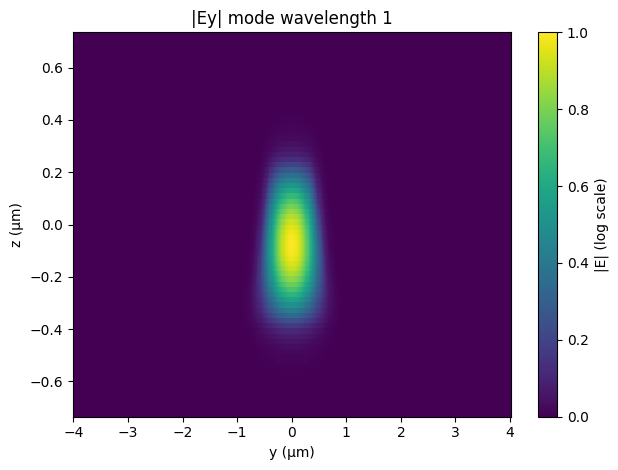

Integral Ey dA 1 = (3.6264400209113343e-13+0j)


In [57]:
# E has the form (1, Ny, Nz, 1, 3) → [freq, y, z, mode, component]
import numpy as np
import matplotlib.pyplot as plt

data = np.load(f"./{lambda0*1e9}nm files/best_mode_solution_{lambda0*1e9}nm.npz", allow_pickle=True)

Electric_fields = data["Electric_fields"].tolist()   # list of dicts
n_effs = data["n_effs"]
indices = data["indices"]
h_best = data["best_h"]
w_best = data["best_w"]


for i in range(len(Electric_fields)):
    data = Electric_fields[i]  # Electric_fields[wavelenght, selected mode more than 0.99 of TE polarization] 

    y = data['y'].squeeze()   # (Ny,)
    z = data['z'].squeeze()   # (Nz,)

    # Elige componente: 0=Ex, 1=Ey, 2=Ez
    Electric_field_x = data['E'][0, :, :, 0, 0]      # (Ny, Nz) → Ey del modo 1
    Electric_field_y = data['E'][0, :, :, 0, 1] 
    Electric_field_z = data['E'][0, :, :, 0, 2] 
    Magnitude_electricfield = np.sqrt(Electric_field_x**2+Electric_field_y**2+Electric_field_z**2)

    E_abs = np.abs(Electric_field_y)

    Y, Z = np.meshgrid(y * 1e6, z * 1e6, indexing='ij')  # pasar a micras

    import matplotlib.pyplot as plt
    import matplotlib.colors as colors

    plt.figure()
    plt.pcolormesh(Y, Z, E_abs,
                shading='auto')
                #norm=colors.LogNorm(vmin=E_abs[E_abs>0].min(), vmax=E_abs.max()))
    plt.xlabel('y (µm)')
    plt.ylabel('z (µm)')
    plt.title(f'|Ey| mode wavelength {i}')
    plt.colorbar(label='|E| (log scale)')
    plt.tight_layout()
    plt.show()


    I = Electric_field_y   # intensidad

    # integrar primero en z, luego en y (regla del trapecio)
    int_z  = np.trapezoid(I, z, axis=1)       # resultado depende de y
    int_yz = np.trapezoid(int_z, y, axis=0)   # escalar: ∫∫ |E|^2 dy dz

    print(f"Integral Ey dA {i} =", int_yz)
